In [ ]:
!pip install keras_nlp

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import numpy as np

Using TensorFlow backend


In [ ]:
the_enchanted_april_url = 'https://www.gutenberg.org/cache/epub/16389/pg16389.txt'
sherlock_holmes_url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
dracula_url = 'https://www.gutenberg.org/cache/epub/345/pg345.txt'
tale_of_two_cities_url = 'https://www.gutenberg.org/files/98/98-0.txt'

paths = [the_enchanted_april_url, sherlock_holmes_url, dracula_url, tale_of_two_cities_url]
names = ['The Enchanted April', 'The Adventured of Sherlock Holmes', 'Dracula', 'The Tale of Two Cities']
texts = ''
for index, path in enumerate(paths):
    filepath = keras.utils.get_file(f'{names[index]}.txt', origin=path)
    text = ''
    with open(filepath, encoding='utf-8') as f:
        text = f.read()
        # First 50 lines are the Gutenberg intro and preface
        # Skipping first 10k characters for each book should be approximately
        # removing the intros and prefaces.
        texts += text[10000:]

In [ ]:
texts[15000:15500]

'eager, shy face, and her thin shoulders, and the look of childish\nlonging in her eyes for something that she was sure was going to make\nher happy. No; such things didn’t make people happy, such fleeting\nthings. Mrs. Arbuthnot had learned in her long life with Frederick—he\nwas her husband, and she had married him at twenty and was now\nthirty-three—where alone true joys are to be found. They are to be\nfound, she now knew, only in daily, in hourly, living for others;\nthey are to be found only—hadn’'

In [ ]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
# Split the combined texts into words
words = re.findall(r'\b\w+\b', texts.lower())  # Tokenize by words and convert to lowercase

# Data Cleaning: Remove stopwords and punctuation
stopwords = set(['the', 'and', 'to', 'of', 'a', 'in', 'that', 'it', 'i', 'was', 'as', 'with', 'for', 'but', 'at', 'on', 'by', 'is'])
filtered_words = [word for word in words if word not in stopwords and word.isalnum()]

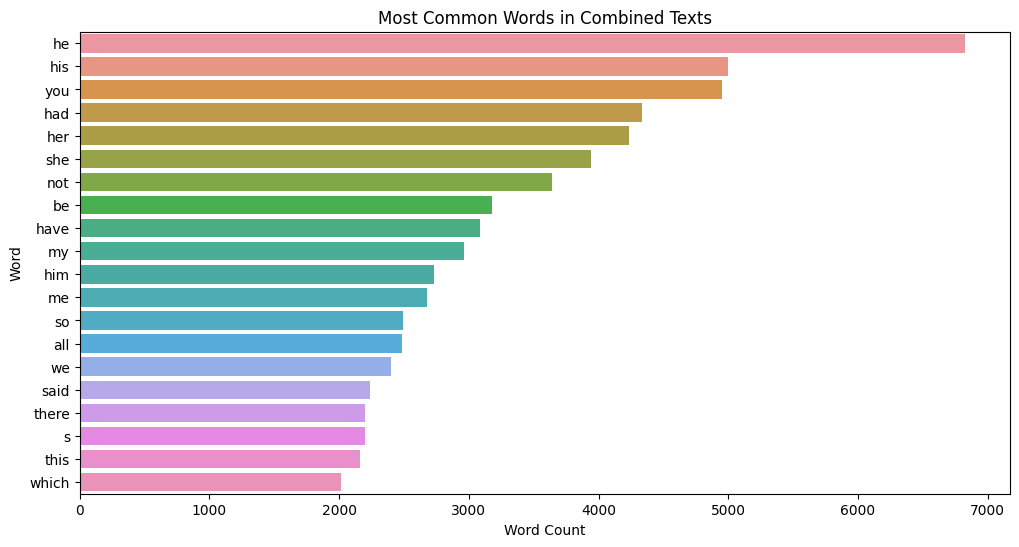

In [ ]:
# Data Visualization
word_counter = Counter(filtered_words)
common_words = word_counter.most_common(20)  # Get the most common words and their counts

# Create a bar plot of the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words])
plt.title('Most Common Words in Combined Texts')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

In [ ]:
text_list = texts.split('.')
len(text_list)

27034

In [ ]:
text_list = list(filter(None, text_list))

import random
random.shuffle(text_list)

In [ ]:
length = len(text_list)
text_train = text_list[:int(0.7*length)]
text_test = text_list[int(0.7*length):int(0.85*length)]
text_valid = text_list[int(0.85*length):]

In [ ]:
from tensorflow.keras.layers import TextVectorization

def custom_standardization(input_string):
    sentence = tf.strings.lower(input_string)
    sentence = tf.strings.regex_replace(sentence, "\n", " ")
    return sentence

maxlen = 50

In [ ]:
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)

vectorize_layer.adapt(text_list)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
vocab_size = len(vocab)
vocab_size

33737

In [ ]:
index_lookup = dict(zip(range(len(vocab)), vocab))
index_lookup[9]

'that'

In [ ]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(text_train)
train_dataset = train_dataset.shuffle(buffer_size=256)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(text_test)
test_dataset = test_dataset.shuffle(buffer_size=256)
test_dataset = test_dataset.batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices(text_valid)
valid_dataset = valid_dataset.shuffle(buffer_size=256)
valid_dataset = valid_dataset.batch(batch_size)

In [ ]:
def preprocess_text(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_dataset = train_dataset.map(preprocess_text)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_text)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.map(preprocess_text)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
for entry in train_dataset.take(1):
    print(entry)

(<tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[  25, 1953,   17, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 566,  593,   24, ...,    0,    0,    0],
       ...,
       [  31,  588,    4, ...,    0,    0,    0],
       [1051, 1108,   84, ...,    0,    0,    0],
       [   7,   63,   23, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[1953,   17, 3458, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 593,   24,  343, ...,    0,    0,    0],
       ...,
       [ 588,    4,  315, ...,    0,    0,    0],
       [1108,   84,   13, ...,    0,    0,    0],
       [  63,   23,  112, ...,    0,    0,    0]])>)


In [ ]:
embed_dim = 128
num_heads = 4

def create_model():
    inputs = keras.layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, maxlen, embed_dim)(inputs)
    decoder = keras_nlp.layers.TransformerDecoder(intermediate_dim=embed_dim,
                                                            num_heads=num_heads,
                                                            dropout=0.5)(embedding_layer)

    outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',
        metrics=[keras_nlp.metrics.Perplexity(), 'accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddi  (None, 50, 128)           4324736   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_decoder (Trans  (None, 50, 128)           99584     
 formerDecoder)                                                  
                                                                 
 dense_2 (Dense)             (None, 50, 33737)         4352073   
                                                                 
Total params: 8776393 (33.48 MB)
Trainable params: 8776393 (33.48 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
class TextSampler(keras.callbacks.Callback):
    def __init__(self, start_prompt, max_tokens):
        self.start_prompt = start_prompt
        self.max_tokens = max_tokens

    # Helper method to choose a word from the top K probable words with respect to their probabilities
    # in a sequence
    def sample_token(self, logits):
        logits, indices = tf.math.top_k(logits, k=5, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def on_epoch_end(self, epoch, logs=None):
        decoded_sample = self.start_prompt

        for i in range(self.max_tokens-1):
            tokenized_prompt = vectorize_layer([decoded_sample])[:, :-1]
            predictions = self.model.predict([tokenized_prompt], verbose=0)
            # To find the index of the next word in the prediction array.
            # The tokenized prompt is already shorter than the original decoded sample
            # by one, len(decoded_sample.split()) is two words ahead - so we remove 1 to get
            # the next word in the sequence
            sample_index = len(decoded_sample.strip().split())-1

            sampled_token = self.sample_token(predictions[0][sample_index])
            sampled_token = index_lookup[sampled_token]
            decoded_sample += " " + sampled_token

        print(f"\nSample text:\n{decoded_sample}...\n")

# First 5 words of a random sentence to be used as a seed
random_sentence = ' '.join(random.choice(text_valid).replace('\n', ' ').split(' ')[:4])
sampler = TextSampler(random_sentence, 30)
reducelr = keras.callbacks.ReduceLROnPlateau(patience=10, monitor='val_loss')

In [ ]:
model = create_model()
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10, callbacks=[sampler, reducelr])

Epoch 1/10
294/294 [==============================] - ETA: 0s - loss: 3.1558 - perplexity: 23.4719 - accuracy: 0.6669
Sample text:
 And then the same and i have a man  of her to the little man in a own little of his man  was in the little of the own of...

294/294 [==============================] - 2172s 7s/step - loss: 3.1558 - perplexity: 23.4719 - accuracy: 0.6669 - val_loss: 2.1821 - val_perplexity: 8.8647 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 2/10
294/294 [==============================] - ETA: 0s - loss: 2.0527 - perplexity: 7.7889 - accuracy: 0.6988
Sample text:
 And then the man who is no other way in her face in the door  in the other of his eyes and i could not know it is to me in...

294/294 [==============================] - 2091s 7s/step - loss: 2.0527 - perplexity: 7.7889 - accuracy: 0.6988 - val_loss: 2.0683 - val_perplexity: 7.9110 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 3/10
294/294 [==============================] - ETA: 0s - loss: 1.8513 - perplexity: 6.3680 - 

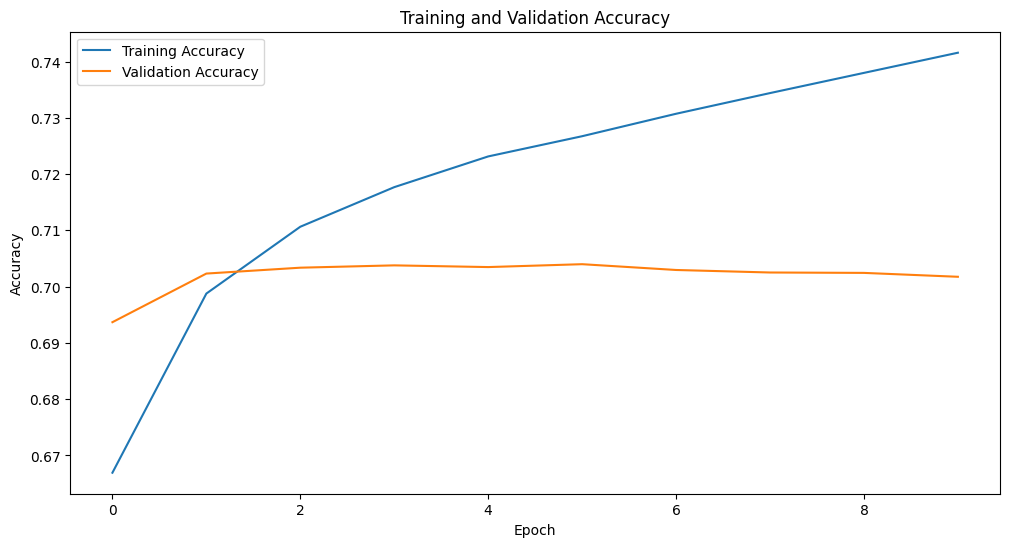

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already executed the code to train the model and have 'history' available
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

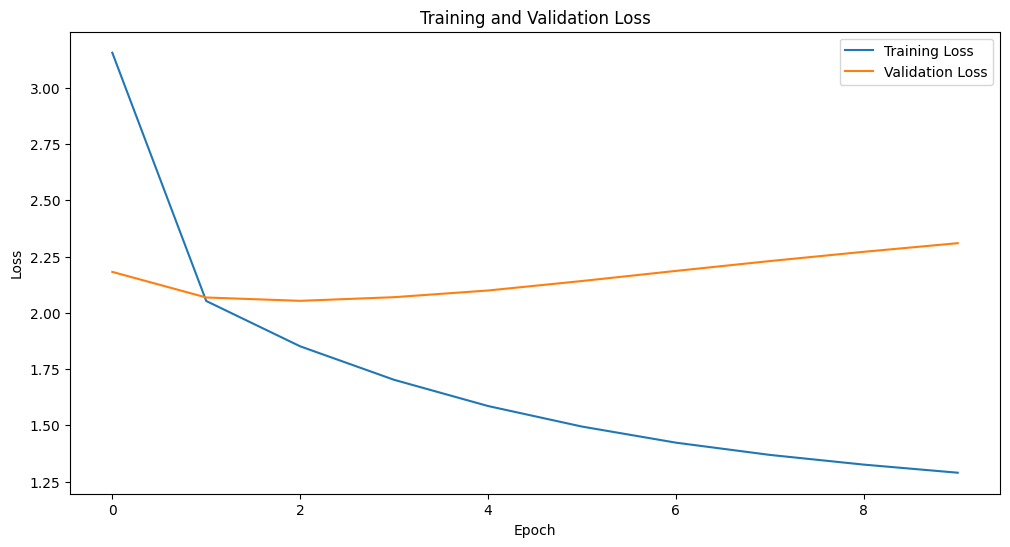

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def sample_token(logits):
        logits, indices = tf.math.top_k(logits, k=5, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)


In [ ]:
def generate_text(prompt, response_length=20):
    decoded_sample = prompt
    for i in range(response_length-1):
        tokenized_prompt = vectorize_layer([decoded_sample])[:, :-1]
        predictions = model.predict([tokenized_prompt], verbose=0)
        sample_index = len(decoded_sample.strip().split())-1

        sampled_token = sample_token(predictions[0][sample_index])
        sampled_token = index_lookup[sampled_token]
        decoded_sample += " " + sampled_token
    return decoded_sample

In [ ]:
generate_text('the truth ultimately is')

'the truth ultimately is the converse is middle-aged, that was intellectual?” for you_, he said holmes  as i had been accorded i'

In [ ]:
generate_text('the truth ultimately is')

'the truth ultimately is in a woman, blurted out:-- “i know how i am so i can see that i do not have'

In [ ]:
def chatbot_interaction():
    print("Chatbot: Hi there! I'm your chatbot. Type 'exit' to end the conversation.")

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("Chatbot: Goodbye!")
            break

        bot_response = generate_text(user_input)
        print("Chatbot:", bot_response)

if __name__ == "__main__":
    chatbot_interaction()

Chatbot: Hi there! I'm your chatbot. Type 'exit' to end the conversation.
You: waterfall
Chatbot: waterfall a little income,” i represent that the village is the count dracula, that i choose the other beer, no
You: Beneath the starlit sky's embrace
Chatbot: Beneath the starlit sky's embrace it, rose? see how many months? nine, black downpour, the devil of the place--of blood--before a few words to
You: A symphony of words, a poet's flight
Chatbot: A symphony of words, a poet's flight of gripping fingers were dilated and sat down on a few seconds of white flowers, and with a four-wheeler,
You: Bloodstained secrets and whispered lies
Chatbot: Bloodstained secrets and whispered lies on his neighbour, and, having authors not know what it will be a word that it will do it
You: In the courtroom of justice, a trial of souls
Chatbot: In the courtroom of justice, a trial of souls and i could see nothing; i have written my life and i have to do with a man to
You: n the shadows of the past, a rec